# **Acamica Final Project**

In this project we will focus on comparing models to make time series predictions corresponding to the vehicle flow through a toll station in Buenos Aires. The models we will compare are SARIMA and two types of neural networks (MLP and LSTM). The data can be found at:https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa





### **Importings**

In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from math import sqrt
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing
import itertools
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)

In [103]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Part A. Dataset preprocessing and EDA**

In [104]:
data_2019 = pd.read_csv('/content/drive/MyDrive/Curso_Acamica/Proyecto 3 Series de Tiempo/flujo-vehicular-2019.csv', sep = ',')
data_2018 = pd.read_csv('/content/drive/MyDrive/Curso_Acamica/Proyecto 3 Series de Tiempo/flujo-vehicular-2018.csv', sep = ',')
data_2017 = pd.read_csv('/content/drive/MyDrive/Curso_Acamica/Proyecto 3 Series de Tiempo/flujo-vehicular-2017.csv', sep = ',')

In [105]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

In [106]:
#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

In [107]:
#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True,axis=1)

In [108]:
dataset.head()

,fecha,hora_fin,dia,sentido,tipo_vehiculo,cantidad_pasos
80,2019-01-01,2,Martes,Centro,Liviano,537
86,2019-01-01,2,Martes,Centro,Pesado,1
88,2019-01-01,2,Martes,Provincia,Liviano,443
94,2019-01-01,2,Martes,Provincia,Pesado,1
149,2019-01-01,3,Martes,Centro,Liviano,769


In [109]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [110]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [111]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Pesado,1,2017-01-01
1,Domingo,Provincia,Liviano,9,2017-01-01
2,Domingo,Provincia,Liviano,644,2017-01-01
3,Domingo,Provincia,Pesado,6,2017-01-01
4,Domingo,Provincia,Pesado,1,2017-01-01


## **EDA**

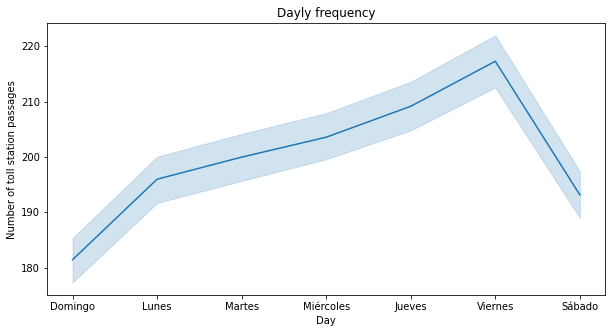

In [112]:
plt.figure(figsize = (10,5))

sns.lineplot(x='dia',y='cantidad_pasos', data=dataset)
plt.title('Dayly frequency')
plt.xlabel('Day')
plt.ylabel('Number of toll station passages')
plt.show()

From the previous figure we can infer that the amount of steps in the toll station "Illia" using the form of payment "Cash" increases throughout the week, having its peak on Friday.

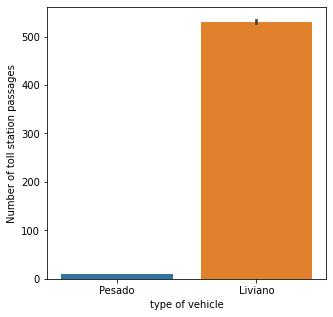

In [113]:
plt.figure(figsize=(5,5))
sns.barplot(x='tipo_vehiculo', y='cantidad_pasos', data=dataset)
#plt.title('type of vehicle')
plt.xlabel('type of vehicle')
plt.ylabel('Number of toll station passages')
plt.show()

The light traffic is the type of vehicle that predominates in the station "Illia" with the form of payment "Cash".

In [114]:
dataset = dataset.set_index('fecha')
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos
fecha,,,,
2017-01-01,Domingo,Provincia,Pesado,1
2017-01-01,Domingo,Provincia,Liviano,9
2017-01-01,Domingo,Provincia,Liviano,644
2017-01-01,Domingo,Provincia,Pesado,6
2017-01-01,Domingo,Provincia,Pesado,1


### **Visualizations**

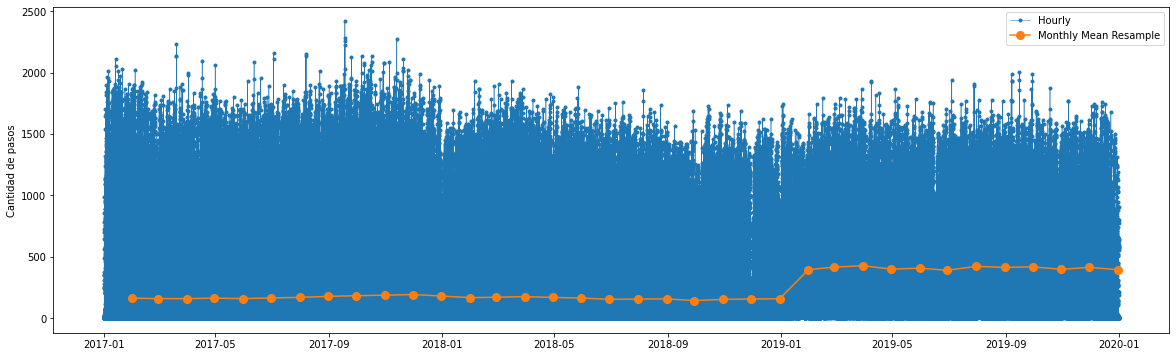

In [115]:
y = dataset['cantidad_pasos']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Hourly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Cantidad de pasos')
ax.legend();

In this first visualization of the time series we can observe that around 01-2019 there is an important jump in the monthly average of passages through the toll station 'Ilia' using the payment form 'Cash'. In addition, a big change in the average around January 2019 is observed.

In [116]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D').sum()
print(diario.shape)
diario.head()

(1095, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


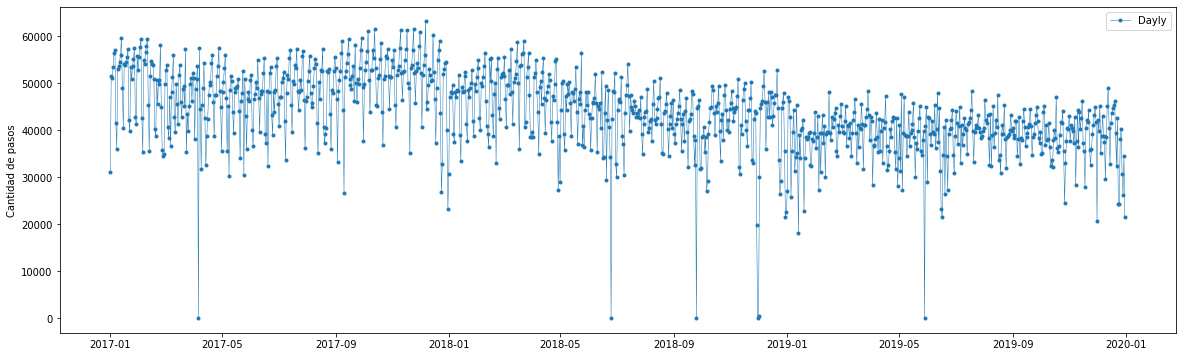

In [117]:
y = diario.cantidad_pasos
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Dayly')
ax.set_ylabel('Cantidad de pasos')
ax.legend();

In [118]:
#Imputamos los valores con datos igual a 0
diario.cantidad_pasos[diario.cantidad_pasos < 10000] = np.nan

In [119]:
diario = diario.interpolate()

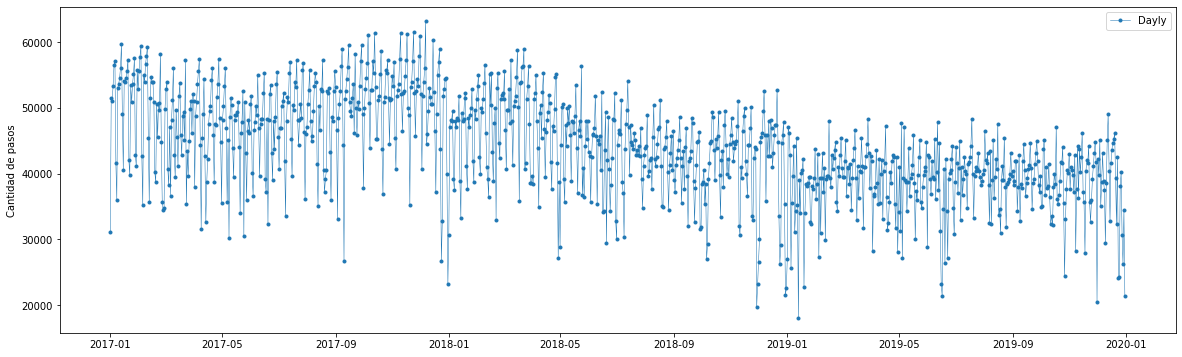

In [120]:
y = diario.cantidad_pasos
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Dayly')
ax.set_ylabel('Cantidad de pasos')
ax.legend();

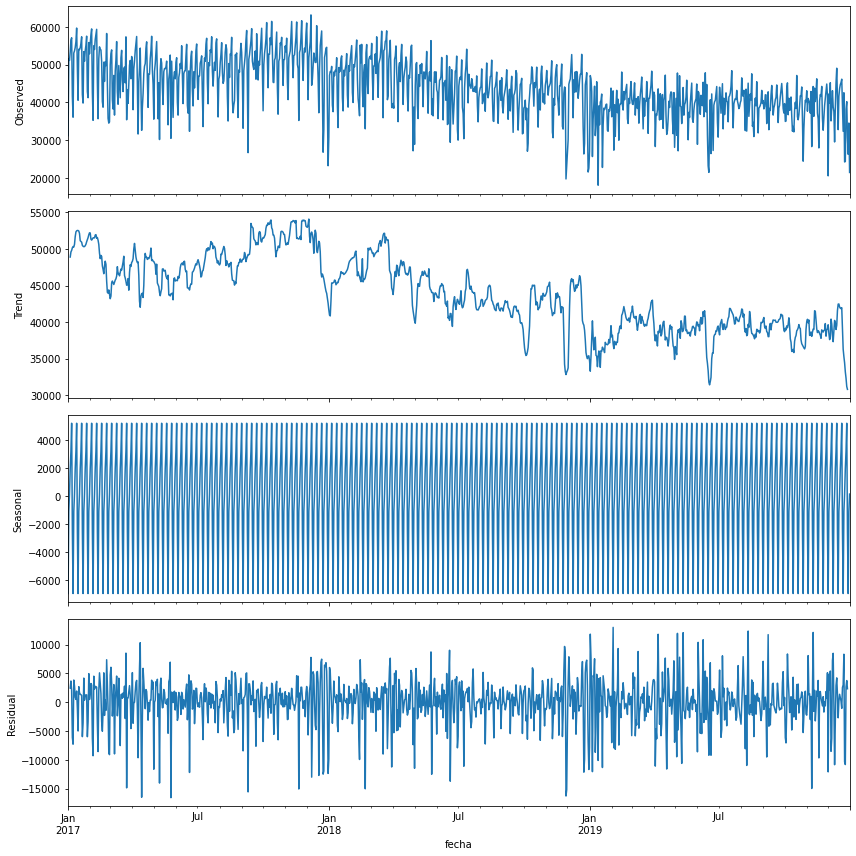

In [121]:
from statsmodels.tsa.seasonal import seasonal_decompose 

result = seasonal_decompose(diario.cantidad_pasos, model='aditive') 

import matplotlib 
matplotlib.rcParams['figure.figsize'] = [12,12] 

result.plot() 
plt.savefig('statsmodeldescomp.png')
plt.show()

After looking at the four pieces of decomposed graphs, we can tell that our dataset has an overall decreasing trend as well as a weekly seasonality. 

## **Making the data stationary**

We need to check wether the dataset is stationary or not. A dataset is stationary if its statistical properties like mean, variance and autocorrelation do not change over time. Since most time series forecasting models use stationary-series to make predictions, we need to 'stationarize' the time series as part of fitting a model.

In [122]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=7).mean() 
    rolstd = pd.Series(timeseries).rolling(window=7).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

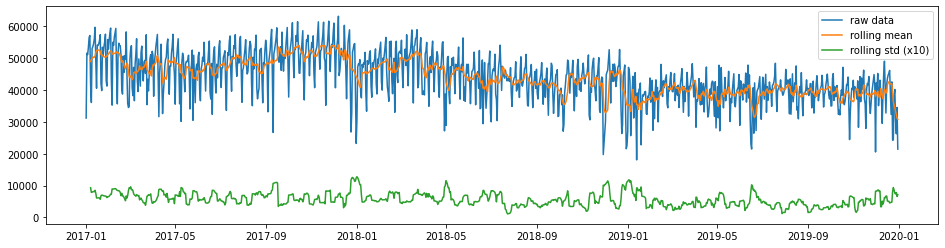

In [123]:
test_stationarity(y,'raw data')

Both the mean and standard deviation change much over time. Visually then it is observed that the series would not be stationary. But in this case, since the y-axis has such a large scale, we can not confidently conclude that our data is stationary by simply viewing the above graph. Therefore, we should do another test for stationarity.

The ADF approach is essentially a statistical significance test that compares the p-value with the critical values and does hypothesis testing. Using this test, we can determine whether the processed data is stationary or not with different levels of confidence. 

In [124]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [125]:
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = -1.752
P-value = 0.404
Critical values :
	1%: -3.4364533503600962 - The data is not stationary with 99% confidence
	5%: -2.864234857527328 - The data is not stationary with 95% confidence
	10%: -2.568204837482531 - The data is not stationary with 90% confidence


The results showed that the data is not stationary. Therefore, some models cannot be applied unless the series is made stationary. Next, three ways to obtain a stationary series from non-stationary data will be tested.

#### **1. Detrending**

 > Is the de-trended data stationary ?
Test statistic = -9.239
P-value = 0.000
Critical values :
	1%: -3.4364992651202697 - The data is  stationary with 99% confidence
	5%: -2.8642551098431968 - The data is  stationary with 95% confidence
	10%: -2.5682156239065925 - The data is  stationary with 90% confidence


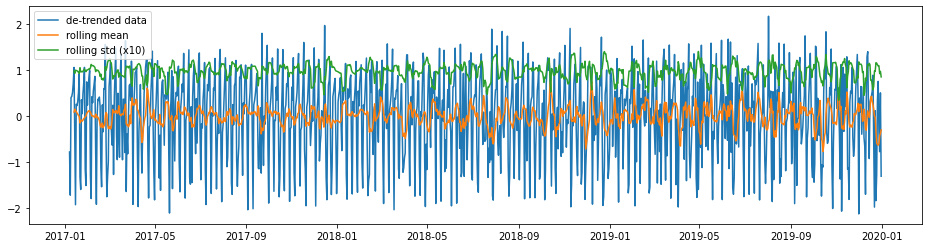

In [126]:
# Detrending
y_detrend =  (y - y.rolling(window=7).mean())/y.rolling(window=7).std()

test_stationarity(y_detrend.dropna(),'de-trended data')
ADF_test(y_detrend.dropna(),'de-trended data')

The results showed that the data is now stationary.

#### **2. Differencing**

 > Is the 1 lag differenced data stationary ?
Test statistic = -12.512
P-value = 0.000
Critical values :
	1%: -3.4364533503600962 - The data is  stationary with 99% confidence
	5%: -2.864234857527328 - The data is  stationary with 95% confidence
	10%: -2.568204837482531 - The data is  stationary with 90% confidence


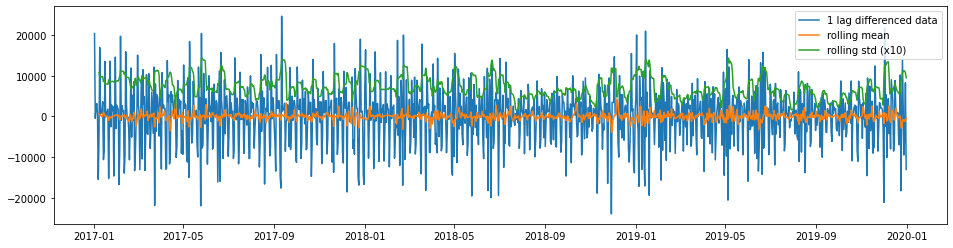

In [127]:
# Differencing
y_lag =  y - y.shift()

test_stationarity(y_lag.dropna(),'1 lag differenced data')
ADF_test(y_lag.dropna(),'1 lag differenced data')

### **3. Combining Detrending and Differencing**

 > Is the 1 lag differenced de-trended data stationary ?
Test statistic = -16.525
P-value = 0.000
Critical values :
	1%: -3.436487721786906 - The data is  stationary with 99% confidence
	5%: -2.8642500182800266 - The data is  stationary with 95% confidence
	10%: -2.568212912125293 - The data is  stationary with 90% confidence


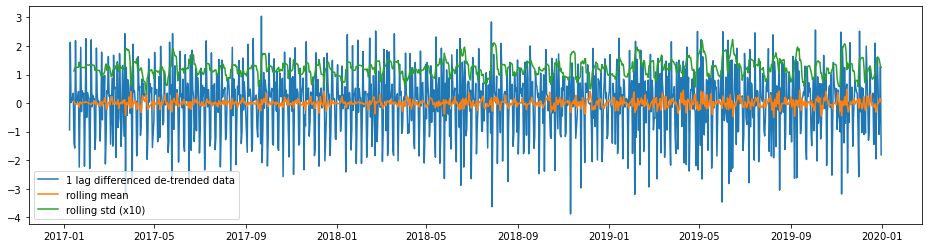

In [128]:
# Detrending + Differencing

y_lag_detrend =  y_detrend - y_detrend.shift()

test_stationarity(y_lag_detrend.dropna(),'1 lag differenced de-trended data')
ADF_test(y_lag_detrend.dropna(),'1 lag differenced de-trended data')

We can notice that all of the above transformation have a small p-value, but the combination of detrending and differencing transformed time series has a much more negative test statistic. This means the detrending-differencing tranformation is better. 

In [129]:
y_lag_detrend2 = y_lag_detrend.dropna()
y_lag2 = y_lag.dropna()

## Part B. Forecasting


In [130]:
train_size=int(len(y) *0.7) # 70% for training
test_size = int(len(dataset)) - train_size

train_y = y[:train_size].dropna()
test_y = y[train_size:].dropna()

#print(len(test_y))
#cut_off=-90
#y_to_train,y_to_test= y.iloc[:cut_off],y.iloc[cut_off:]
#predict_date = len(y_to_train) - len(y_to_test) # the number of data points for the test set
#print(predict_date, len(y_to_test))

### **SARIMA - Benchmark model**

Seasonal Autoregresive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component. It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving avergae (MA) for the seasonal component of the series, as well an aditional parameter for the period of seasonality.

The trend elements (p,q,d) can be chosen through careful analysis of ACF and PACF plots looking at correlations of the recent time steps. Similarly, ACF and PACF plots can be analyzed to specify values for the seasonal model by looking at correlation at seasonal lag time steps.

Text(0, 0.5, 'PACF')

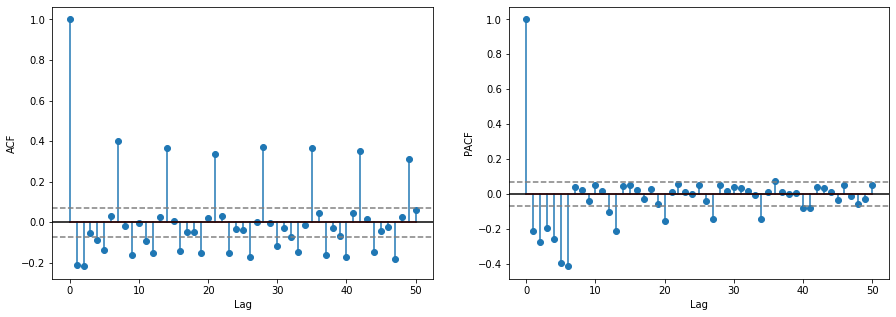

In [131]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(y_lag2, nlags=50)
lag_pacf = pacf(y_lag2, nlags=50)

#Plot ACF
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.stem(lag_acf)
plt.axhline(y=0, linestyle='-', color='black')
plt.axhline(y=-1.96/np.sqrt(len(train_y)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_y)), linestyle='--', color='gray')
plt.xlabel('Lag')
plt.ylabel('ACF')

#Plot PACF
plt.subplot(122)
plt.stem(lag_pacf)
plt.axhline(y=0, linestyle='-', color='black')
plt.axhline(y=-1.96/np.sqrt(len(train_y)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_y)), linestyle='--', color='gray')
plt.xlabel('Lag')
plt.ylabel('PACF')

According to these plots, we should start with a value of p = 1 and q = 7. But visual inspection of the ACF and PACF can be quite inconclusive and misleading. So, another option is to automate the process of identifying the optimal set of parameters for the seasonal ARIMA time series model. For this we will use a “grid search” to iteratively explore different combinations of parameters.

In [132]:
def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit(maxiter=50)
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

                    print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [133]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)


In [134]:
sarima_grid_search(y,7)

SARIMA(0, 0, 0)x(0, 0, 0, 7) - AIC:26529.13655432939
SARIMA(0, 0, 0)x(0, 0, 1, 7) - AIC:25618.955438939258
SARIMA(0, 0, 0)x(0, 1, 0, 7) - AIC:22085.434556945518
SARIMA(0, 0, 0)x(0, 1, 1, 7) - AIC:21628.159341508202
SARIMA(0, 0, 1)x(0, 1, 1, 7) - AIC:21569.250143287652
SARIMA(1, 0, 1)x(0, 1, 1, 7) - AIC:21506.27725613666
The set of parameters with the minimum AIC is: SARIMA(1, 0, 1)x(0, 1, 1, 7) - AIC:21506.27725613666


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7276      0.021    -34.025      0.000      -0.769      -0.686
ma.L2         -0.1997      0.023     -8.555      0.000      -0.245      -0.154
ma.S.L7       -0.8667      0.027    -32.026      0.000      -0.920      -0.814
ma.S.L14      -0.0422      0.028     -1.525      0.127      -0.096       0.012
sigma2      2.225e+07   1.93e-10   1.16e+17      0.000    2.22e+07    2.22e+07


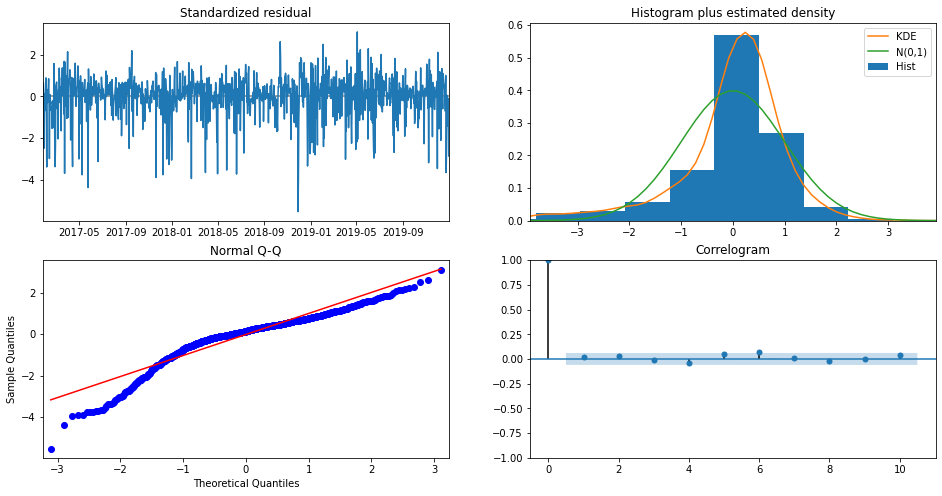

The Root Mean Squared Error of SARIMA with season_length=7 and dynamic = False 4731.74


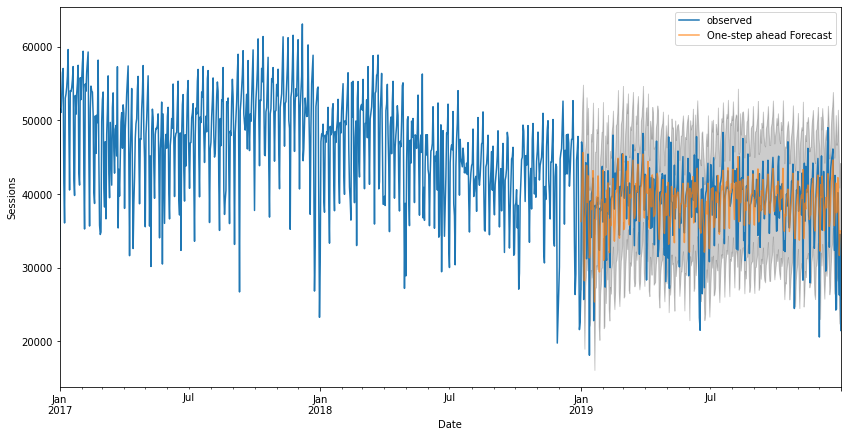

The Root Mean Squared Error of SARIMA with season_length=7 and dynamic = True 9419.8


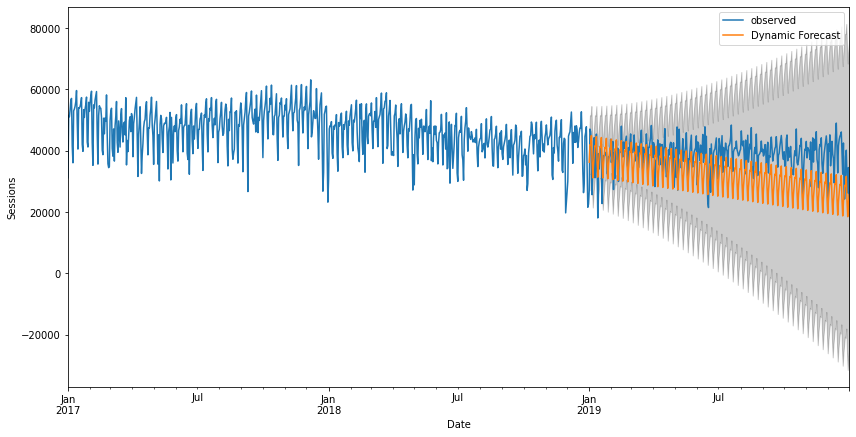

In [135]:
model = sarima_eva(y,(0, 1, 2),(0, 1, 2, 7),7,'2019-01-01' ,test_y)

The diagnostic plots showed before give the following information:
- The top left plot shows the residual over time. We shouldn't find here any seasonaility, as in this case. The residuals over time and it appears to be a white noise with no seasonal component.
- The to right plot, shows that de KDE line follows closely with the N(0,1) line (where N(0,1) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distribuited.
- The qq-plot on the bottom left shows the ordered distribution of residuals (blue dots) almost following the linear trend (red line) of the samples taken from a standard normal distribution with N(0, 1).
- The residuals over time (top left plot) don’t display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

Although we have a good fit, some parameters of our seasonal ARIMA model could be changed to improve our model fit. For example, our grid search only considered a restricted set of parameter combinations, so we may find better models if we widened the grid search.

### **Neural networks: MLP using Keras**

Next a feed-forward network was implemented in Keras.  In order to find the optimal number of nodes in this model, we performed a cross-validated grid-search of the parameters neurons (the number of nodes to use in the network) and the batch_size (the number of training samples used in one iteration during training). But first, the time series was prepared following the procedure find in https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
 

In [136]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [137]:
look_back=90
# load dataset
values = diario.values
# ensure all data is float
values = values.astype('float32')

# frame as supervised learning
reframed = series_to_supervised(values, look_back, 1)
reframed.head()

,var1(t-90),var1(t-89),var1(t-88),var1(t-87),var1(t-86),var1(t-85),var1(t-84),var1(t-83),var1(t-82),var1(t-81),var1(t-80),var1(t-79),var1(t-78),var1(t-77),var1(t-76),var1(t-75),var1(t-74),var1(t-73),var1(t-72),var1(t-71),var1(t-70),var1(t-69),var1(t-68),var1(t-67),var1(t-66),var1(t-65),var1(t-64),var1(t-63),var1(t-62),var1(t-61),var1(t-60),var1(t-59),var1(t-58),var1(t-57),var1(t-56),var1(t-55),var1(t-54),var1(t-53),var1(t-52),var1(t-51),...,var1(t-39),var1(t-38),var1(t-37),var1(t-36),var1(t-35),var1(t-34),var1(t-33),var1(t-32),var1(t-31),var1(t-30),var1(t-29),var1(t-28),var1(t-27),var1(t-26),var1(t-25),var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
90,31183.0,51568.0,51093.0,53332.0,56486.0,57081.0,41587.0,36065.0,53036.0,53601.0,54523.0,56042.0,59651.0,49014.0,40546.0,54061.0,53940.0,54468.0,55548.0,57337.0,42057.0,39804.0,53409.0,50855.0,53657.0,55105.0,57506.0,42831.0,41218.0,55814.0,52842.0,55616.0,57795.0,59423.0,42667.0,35244.0,54963.0,53979.0,56618.0,57882.0,...,45525.0,50722.0,49708.0,58213.0,44850.0,35748.0,34497.0,34825.0,49891.0,52832.0,53876.0,40755.0,38232.0,47117.0,36627.0,48173.0,51247.0,56069.0,42768.0,39493.0,49738.0,45608.0,41210.0,51752.0,53757.0,45887.0,42842.0,48803.0,49320.0,45169.0,57317.0,35383.0,43370.0,39721.0,45029.0,49792.0,51074.0,46235.0,52127.0,50995.0
91,51568.0,51093.0,53332.0,56486.0,57081.0,41587.0,36065.0,53036.0,53601.0,54523.0,56042.0,59651.0,49014.0,40546.0,54061.0,53940.0,54468.0,55548.0,57337.0,42057.0,39804.0,53409.0,50855.0,53657.0,55105.0,57506.0,42831.0,41218.0,55814.0,52842.0,55616.0,57795.0,59423.0,42667.0,35244.0,54963.0,53979.0,56618.0,57882.0,59319.0,...,50722.0,49708.0,58213.0,44850.0,35748.0,34497.0,34825.0,49891.0,52832.0,53876.0,40755.0,38232.0,47117.0,36627.0,48173.0,51247.0,56069.0,42768.0,39493.0,49738.0,45608.0,41210.0,51752.0,53757.0,45887.0,42842.0,48803.0,49320.0,45169.0,57317.0,35383.0,43370.0,39721.0,45029.0,49792.0,51074.0,46235.0,52127.0,50995.0,38045.0
92,51093.0,53332.0,56486.0,57081.0,41587.0,36065.0,53036.0,53601.0,54523.0,56042.0,59651.0,49014.0,40546.0,54061.0,53940.0,54468.0,55548.0,57337.0,42057.0,39804.0,53409.0,50855.0,53657.0,55105.0,57506.0,42831.0,41218.0,55814.0,52842.0,55616.0,57795.0,59423.0,42667.0,35244.0,54963.0,53979.0,56618.0,57882.0,59319.0,45366.0,...,49708.0,58213.0,44850.0,35748.0,34497.0,34825.0,49891.0,52832.0,53876.0,40755.0,38232.0,47117.0,36627.0,48173.0,51247.0,56069.0,42768.0,39493.0,49738.0,45608.0,41210.0,51752.0,53757.0,45887.0,42842.0,48803.0,49320.0,45169.0,57317.0,35383.0,43370.0,39721.0,45029.0,49792.0,51074.0,46235.0,52127.0,50995.0,38045.0,48833.0
93,53332.0,56486.0,57081.0,41587.0,36065.0,53036.0,53601.0,54523.0,56042.0,59651.0,49014.0,40546.0,54061.0,53940.0,54468.0,55548.0,57337.0,42057.0,39804.0,53409.0,50855.0,53657.0,55105.0,57506.0,42831.0,41218.0,55814.0,52842.0,55616.0,57795.0,59423.0,42667.0,35244.0,54963.0,53979.0,56618.0,57882.0,59319.0,45366.0,35647.0,...,58213.0,44850.0,35748.0,34497.0,34825.0,49891.0,52832.0,53876.0,40755.0,38232.0,47117.0,36627.0,48173.0,51247.0,56069.0,42768.0,39493.0,49738.0,45608.0,41210.0,51752.0,53757.0,45887.0,42842.0,48803.0,49320.0,45169.0,57317.0,35383.0,43370.0,39721.0,45029.0,49792.0,51074.0,46235.0,52127.0,50995.0,38045.0,48833.0,50891.0
94,56486.0,57081.0,41587.0,36065.0,53036.0,53601.0,54523.0,56042.0,59651.0,49014.0,40546.0,54061.0,53940.0,54468.0,55548.0,57337.0,42057.0,39804.0,53409.0,50855.0,53657.0,55105.0,57506.0,42831.0,41218.0,55814.0,52842.0,55616.0,57795.0,59423.0,42667.0,35244.0,54963.0,53979.0,56618.0,57882.0,59319.0,45366.0,35647.0,51546.0,...,44850.0,35748.0,34497.0,34825.0,49891.0,52832.0,53876.0,40755.0,38232.0,47117.0,36627.0,48173.0,51247.0,56069.0,42768.0,39493.0,49738.0,45608.0,41210.0,51752.0,53757.0,45887.0,42842.0,48803.0,49320.0,45169.0,5731

In [138]:
# split into train and test sets
values = reframed.values
n_train_days = 365*2 - look_back
train = values[:n_train_days, :]
test = values[n_train_days:, :]
print(train.shape, test.shape)

(640, 91) (365, 91)


In [139]:
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(640, 1, 90) (640,) (365, 1, 90) (365,)


In [140]:
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
x_train=x_train.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
x_train = scaler.fit_transform(x_train)
x_val=x_val.reshape(-1, 1) 
x_val=scaler.transform(x_val)

scaler_Y = MinMaxScaler(feature_range=(-1, 1))
y_train=y_train.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
y_train = scaler.fit_transform(y_train)
y_val=y_val.reshape(-1, 1)
y_val=scaler.transform(y_val)
x_train = x_train.reshape((640, 1, 90))
x_val = x_val.reshape((365, 1, 90))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(640, 1, 90) (640, 1) (365, 1, 90) (365, 1)


In [141]:
def build_model(neurons):
  # Specify the model
  model = Sequential()

  model.add(Dense(neurons, activation='tanh', input_shape = (1,look_back)))
  model.add(Flatten())
  model.add(Dense(1, activation='tanh'))

  # Compile the model
  model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])
  return model


In [142]:
# Construct the Regressor model
import warnings
warnings.filterwarnings("ignore")
regressor = KerasRegressor(build_fn = build_model,verbose=0)
parameters = {'batch_size': [10,20,30], # Take half of the training data
                  'epochs': [25,50,100],
                  'neurons': [10,15,20,100]}
                  
grid_search = GridSearchCV(estimator = regressor,
                               param_grid = parameters,
                               scoring = 'neg_mean_squared_error',
                               cv = 10)

In [143]:
# Fit the various models using the object defined above
import warnings
warnings.filterwarnings("ignore")
grid_search = grid_search.fit(x_train, y_train)
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

In [144]:
print(best_parameters)
print(best_accuracy)

{'batch_size': 10, 'epochs': 25, 'neurons': 10}
-0.05165952518582344


Once the optimal parameters have been found, we construct this model with the following code snippet using the mean_squared_error metric and the adam optimizer.

In [145]:
# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=5)

# Now we build and train the optimal model
model = build_model(neurons=best_parameters['neurons'])

# Fit the model
history=model.fit(x_train, y_train, epochs=best_parameters['epochs'], batch_size=best_parameters['batch_size'], verbose=0, validation_data = (x_val,y_val), callbacks=[early_stopping_monitor])

In [146]:
print(history.history.keys())

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


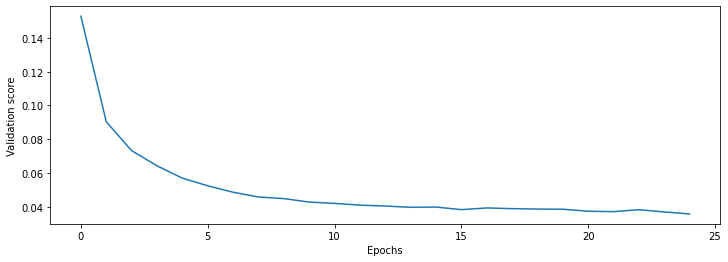

In [147]:
plt.figure(figsize=(12,4))
plt.plot(model.history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()

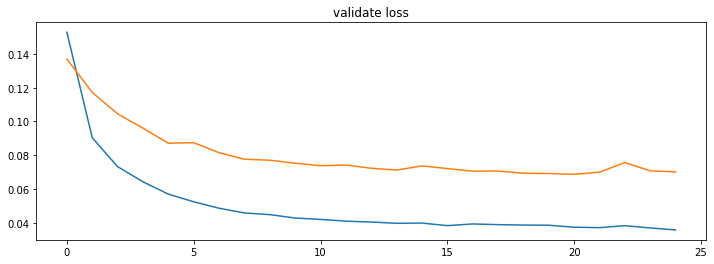

In [148]:
plt.figure(figsize=(12,4))
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

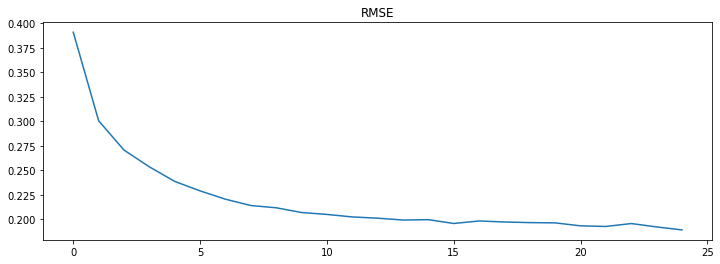

In [149]:
plt.figure(figsize=(12,4))
plt.title('RMSE')
plt.plot(history.history['root_mean_squared_error'])
plt.show()

In [150]:
results=model.predict(x_val)
y_train_pred=model.predict(x_train)

In [151]:
results = results.reshape((365,1))
y_train_pred = y_train_pred.reshape((640,1))
results.shape
y_train_pred.shape

(640, 1)

In [152]:
adimen = [x for x in results]    
inverted = scaler.inverse_transform(adimen)
#inverted

In [153]:
adimen_train = [x for x in y_train_pred]    
inverted_train = scaler.inverse_transform(adimen_train)
#inverted_train

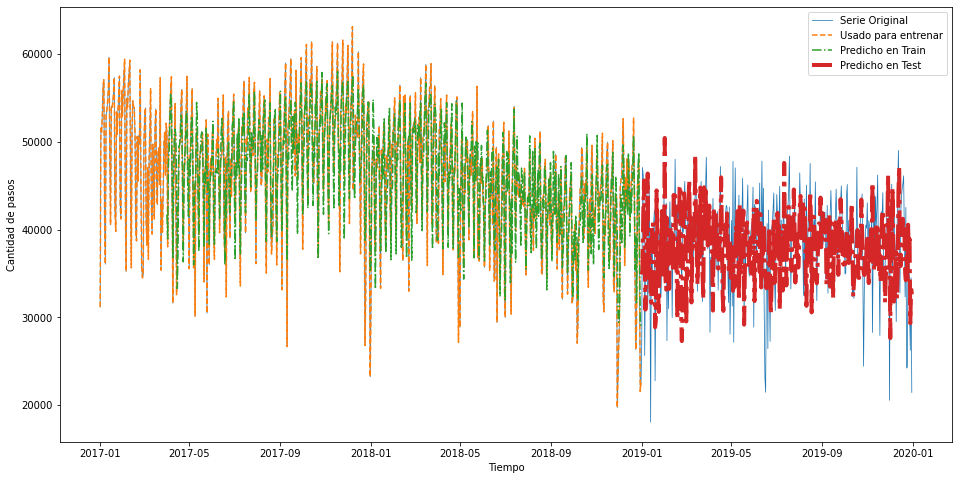

In [154]:
N_train = 365*2 - look_back # cantidad de instancias que vamos a usar para entrenar. 
length_total = n_train_days + 365 + look_back
plt.figure(figsize=(16,8))
plt.plot(diario.index[:length_total], diario[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario.index[:n_train_days + look_back], diario[:n_train_days + look_back],'--', label = 'Usado para entrenar')
plt.plot(diario.index[look_back: look_back + N_train], inverted_train,'-.',label = 'Predicho en Train')
plt.plot(diario.index[n_train_days+look_back: length_total], inverted,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')

plt.show()

In [155]:
loss, rmse = model.evaluate(x_val, y_val, verbose=2)

12/12 - 0s - loss: 0.0702 - root_mean_squared_error: 0.2649


In [156]:
adimen_y_val = [x for x in y_val]    
inverted_y_val = scaler.inverse_transform(adimen_y_val)
#inverted_train

rmse_inverted = sqrt(mean_squared_error(inverted_y_val, inverted)) 
print('RMSE sin normalizar:',round(rmse_inverted, 2))

RMSE sin normalizar: 5747.99


## LSTM: Redes Neuronales Recurrentes

Using the same optimizer, loss function and the GridSearchCV object as the feed-forward neural network the LSTM network is implemented as follows.

In [157]:
def build_model(neurons):
  model = Sequential()
  model.add((LSTM(neurons, input_shape = (1,look_back), activation='tanh')))
  

  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])
  return model

In [158]:
# Construct the Regressor model
regressor = KerasRegressor(build_fn = build_model,verbose=0)
parameters = {'batch_size': [10,15,20,50,100], 
              'epochs':[10,20,30,40],
              'neurons': [2,3,4,5],
              }
grid_search = GridSearchCV(estimator = regressor,
                           param_grid = parameters,
                           scoring = 'neg_mean_squared_error',
                           cv = 10)

In [159]:
# Fit the various models using the object defined above
import warnings
warnings.filterwarnings("ignore")
grid_search = grid_search.fit(x_train, y_train)
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

In [160]:
# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=5)

# Now we build and train the optimal model
model = build_model(neurons=best_parameters['neurons'])

# Store the history of loss of the optimal function
history=model.fit(x_train, y_train, batch_size=best_parameters['batch_size'], epochs=best_parameters['epochs'] ,verbose=0,validation_data = (x_val,y_val), callbacks=[early_stopping_monitor])

In [161]:
print(best_parameters)
print(best_accuracy)

{'batch_size': 15, 'epochs': 30, 'neurons': 4}
-0.04927079193294048


In [162]:
model.summary()

Model: "sequential_1873"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1511 (LSTM)             (None, 4)                 1520      
_________________________________________________________________
dense_2235 (Dense)           (None, 1)                 5         
Total params: 1,525
Trainable params: 1,525
Non-trainable params: 0
_________________________________________________________________


In [163]:
print(history.history.keys())

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


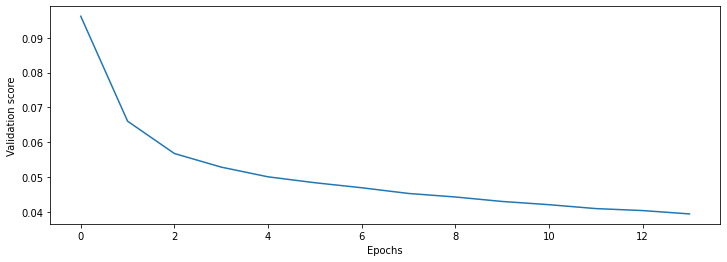

In [164]:
plt.figure(figsize=(12,4))
plt.plot(model.history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()

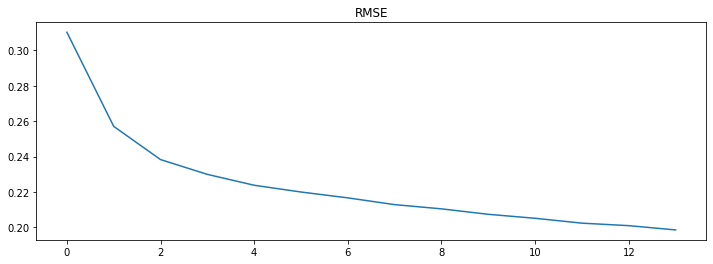

In [165]:
plt.figure(figsize=(12,4))
plt.title('RMSE')
plt.plot(history.history['root_mean_squared_error'])
plt.show()

In [166]:
results=model.predict(x_val)
y_train_pred=model.predict(x_train)

results = results.reshape((365,1))
y_train_pred = y_train_pred.reshape((640,1))
#results.shape
#y_train_pred.shape

adimen = [x for x in results]    
inverted = scaler.inverse_transform(adimen)
#inverted

adimen_train = [x for x in y_train_pred]    
inverted_train = scaler.inverse_transform(adimen_train)
#inverted_train

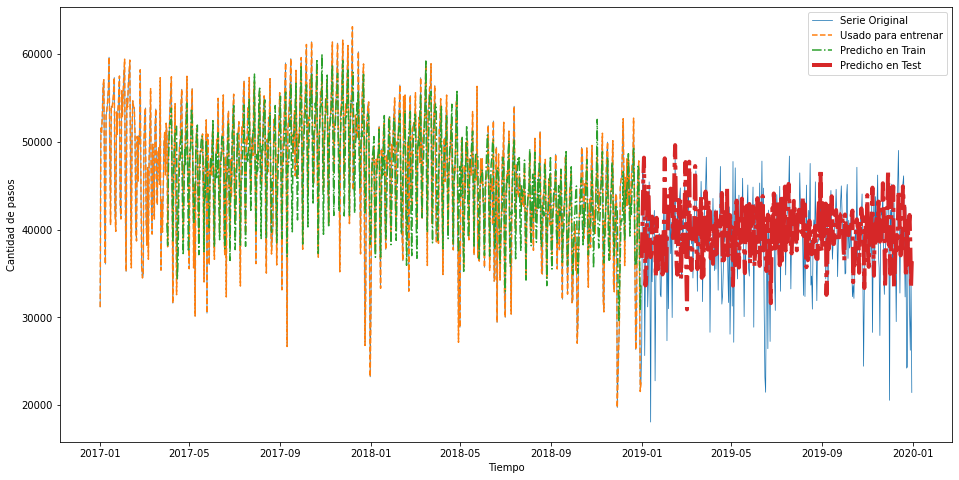

In [167]:
N_train = 365*2 - look_back # cantidad de instancias que vamos a usar para entrenar. 
length_total = n_train_days + 365 + look_back
plt.figure(figsize=(16,8))
plt.plot(diario.index[:length_total], diario[:length_total],lw = 0.75, label = 'Serie Original')
plt.plot(diario.index[:n_train_days + look_back], diario[:n_train_days + look_back],'--', label = 'Usado para entrenar')
plt.plot(diario.index[look_back: look_back + N_train], inverted_train,'-.',label = 'Predicho en Train')
plt.plot(diario.index[n_train_days+look_back: length_total], inverted,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')

plt.show()

In [168]:
loss= model.evaluate(x_val, y_val, verbose=2)

12/12 - 0s - loss: 0.0672 - root_mean_squared_error: 0.2593


In [169]:
adimen_y_val = [x for x in y_val]    
inverted_y_val = scaler.inverse_transform(adimen_y_val)
#inverted_train

rmse_inverted = sqrt(mean_squared_error(inverted_y_val, inverted)) 
print('RMSE sin normalizar:',round(rmse_inverted, 2))

RMSE sin normalizar: 5626.3


### **Conclusions**

The project had some challenges, mainly in getting started and in trying to understand the different approaches to time series modeling. After training three different types of models for time series forecasting, SARIMA model outperformed NN models. However, there are some further improvements that we could have carried out to the implemented models, such as an in-depth exploration of different neural network topologies. 

### **References**

https://www.oscarjavierhernandez.com/other/2018/02/02/udacity_capstone.html#conclusions

https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-two/

https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3